In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import time
import joblib
from collections import Counter

#Hämtar MNIST-datasetet
mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)
print(mnist.DESCR)

#Delar upp datat i X och y
X, y = mnist["data"], mnist["target"]



**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
# Delar upp data i träningsdata, testdata samt sedan delar träningsdata i test och valideringsdata
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [4]:
# Normaliserar data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0
X_train_val = X_train_val / 255.0

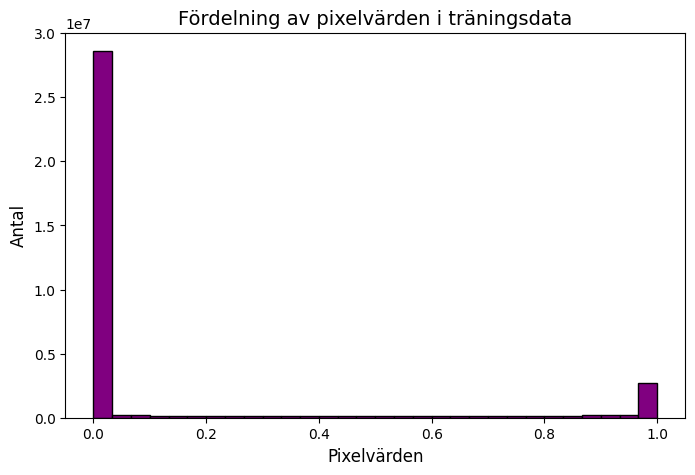

In [5]:
#Histogram över pixelvärden i datasetet
plt.figure(figsize=(8, 5))
plt.hist(X_train.ravel(), bins=30, color="purple", edgecolor="black")
plt.title("Fördelning av pixelvärden i träningsdata", fontsize=14)
plt.xlabel("Pixelvärden", fontsize=12)
plt.ylabel("Antal", fontsize=12)
plt.grid(False)
plt.show()


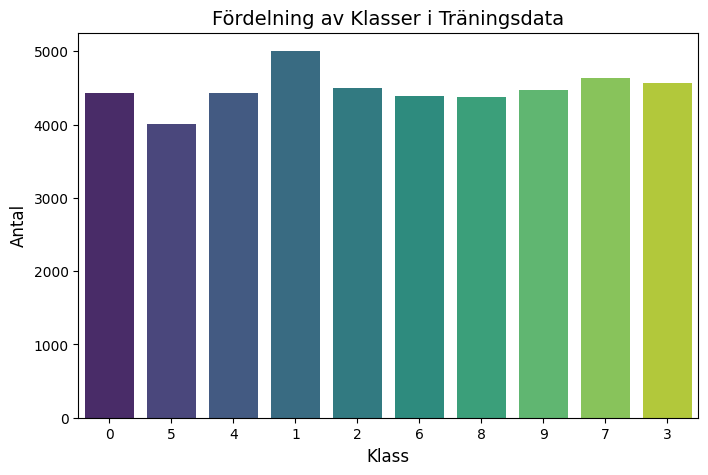

In [6]:
# Fördelning av målvariabler för att se om det är balanserat
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, hue=y_train, palette="viridis", legend=False)
plt.title("Fördelning av Klasser i Träningsdata", fontsize=14)
plt.xlabel("Klass", fontsize=12)
plt.ylabel("Antal", fontsize=12)
plt.grid(False)
plt.show()


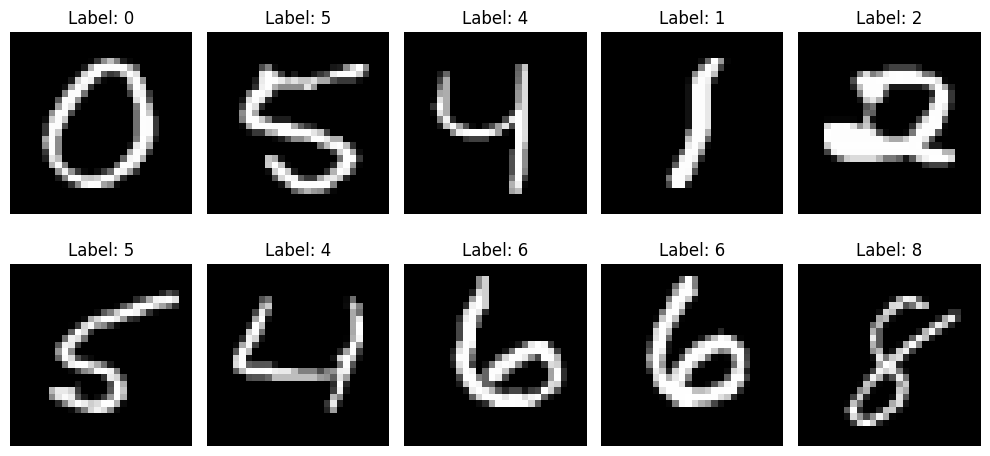

In [7]:
# Skriver ut några exempelbilder
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


**Modellträning**

In [8]:
# Logistic regression, modell 1
start_time = time.time()
log_reg = LogisticRegression(C=1.0, solver="liblinear", max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)

log_reg_train_time = time.time() - start_time
print(f"Träningstid: {log_reg_train_time:.2f} sekunder")

Träningstid: 69.80 sekunder


In [9]:
# Random Forest, modell 2
start_time = time.time() 
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_train_time = time.time() - start_time
print(f"Träningstid: {rf_train_time:.2f} sekunder")

Träningstid: 73.67 sekunder


In [10]:
#MLPClassifier, modell 3
start_time = time.time()
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, alpha=1e-4,
                    solver="sgd", random_state=42, learning_rate_init=0.01)
mlp.fit(X_train, y_train)

mlp_train_time = time.time() - start_time
print(f"Träningstid: {mlp_train_time:.2f} sekunder")

Träningstid: 96.87 sekunder


**Utvärdering**

In [11]:
# Skapa en lista med modellnamn och träningstider
training_times = [
    ["Logistisk Regression", log_reg_train_time],
    ["Random Forest", rf_train_time],
    ["MLPClassifier", mlp_train_time]
]

df_training_times = pd.DataFrame(training_times, columns=["Modell", "Träningstid (sekunder)"])
print(df_training_times.to_string(index=False))



              Modell  Träningstid (sekunder)
Logistisk Regression               69.798469
       Random Forest               73.665134
       MLPClassifier               96.868608


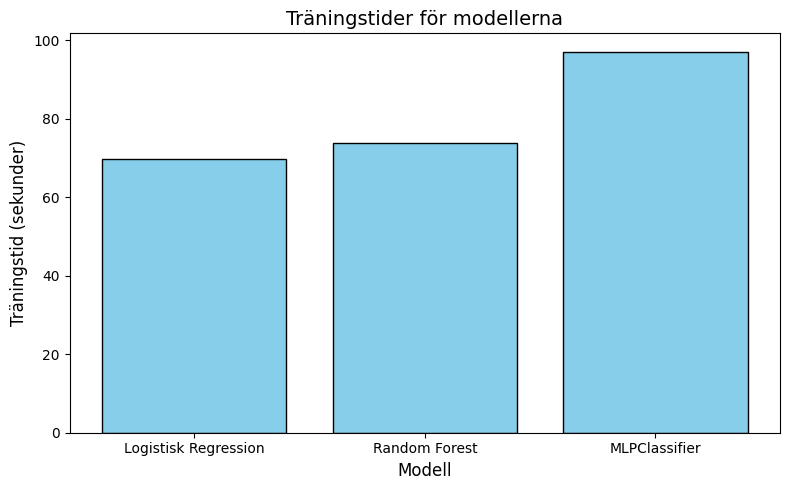

In [12]:
#Testar att skapa en graf över träningstider
models = ["Logistisk Regression", "Random Forest", "MLPClassifier"]
training_times = [log_reg_train_time, rf_train_time, mlp_train_time]

plt.figure(figsize=(8, 5))
plt.bar(models, training_times, color="skyblue", edgecolor="black")
plt.title("Träningstider för modellerna", fontsize=14)
plt.xlabel("Modell", fontsize=12)
plt.ylabel("Träningstid (sekunder)", fontsize=12)
plt.tight_layout()
plt.show()


In [13]:
# Utvärderar modeller på valideringsdatan och spara resultaten
models = {
    "Logistisk Regression": log_reg,
    "Random Forest": rf,
    "MLPClassifier": mlp
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_val)  
    accuracy = accuracy_score(y_val, y_pred) 
    report = classification_report(y_val, y_pred) 
    cm = confusion_matrix(y_val, y_pred)  

    results[name] = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": cm
    }



Modell: Logistisk Regression
Accuracy: 0.9146
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      1126
           1       0.95      0.98      0.96      1274
           2       0.92      0.89      0.91      1106
           3       0.89      0.90      0.89      1144
           4       0.92      0.93      0.92      1104
           5       0.89      0.87      0.88      1039
           6       0.94      0.94      0.94      1096
           7       0.94      0.93      0.93      1149
           8       0.87      0.85      0.86      1090
           9       0.88      0.87      0.88      1072

    accuracy                           0.91     11200
   macro avg       0.91      0.91      0.91     11200
weighted avg       0.91      0.91      0.91     11200



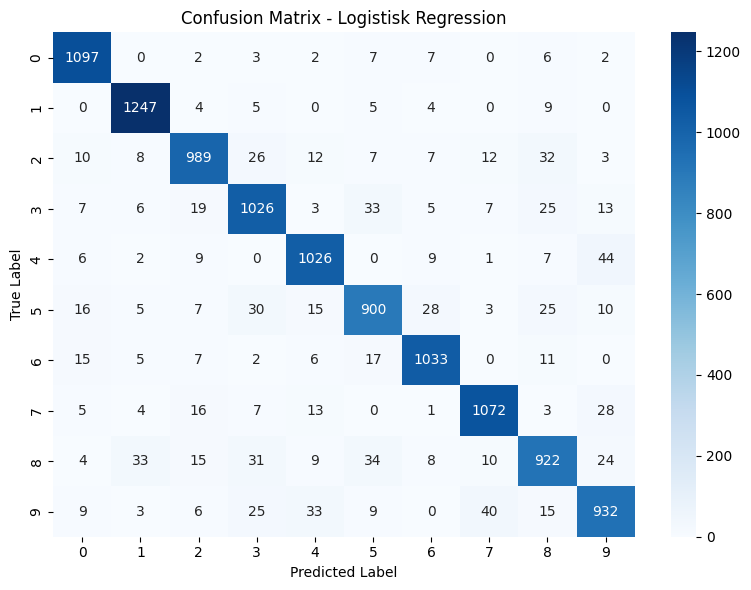


Modell: Random Forest
Accuracy: 0.9666
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1126
           1       0.99      0.99      0.99      1274
           2       0.97      0.96      0.97      1106
           3       0.95      0.96      0.96      1144
           4       0.97      0.97      0.97      1104
           5       0.97      0.96      0.97      1039
           6       0.97      0.97      0.97      1096
           7       0.97      0.97      0.97      1149
           8       0.96      0.95      0.95      1090
           9       0.95      0.94      0.94      1072

    accuracy                           0.97     11200
   macro avg       0.97      0.97      0.97     11200
weighted avg       0.97      0.97      0.97     11200



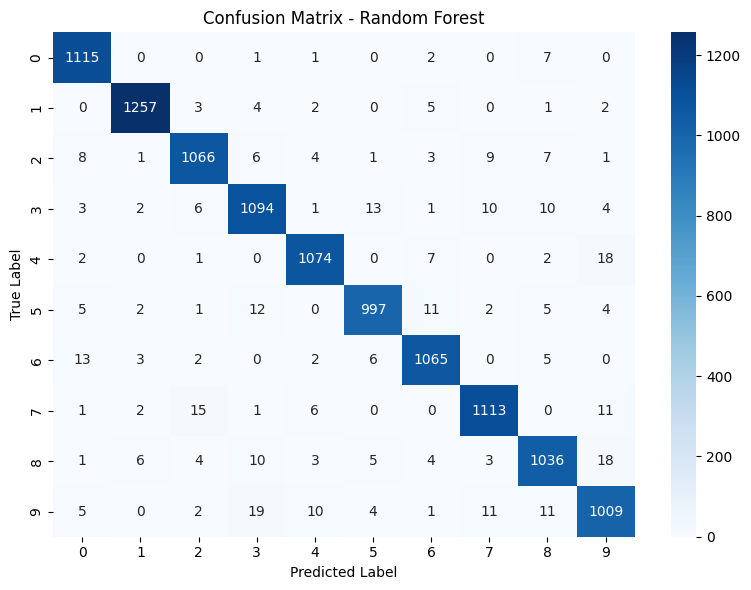


Modell: MLPClassifier
Accuracy: 0.9761
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1126
           1       0.99      0.99      0.99      1274
           2       0.97      0.98      0.97      1106
           3       0.97      0.97      0.97      1144
           4       0.98      0.98      0.98      1104
           5       0.98      0.97      0.97      1039
           6       0.98      0.97      0.97      1096
           7       0.98      0.98      0.98      1149
           8       0.96      0.98      0.97      1090
           9       0.97      0.96      0.97      1072

    accuracy                           0.98     11200
   macro avg       0.98      0.98      0.98     11200
weighted avg       0.98      0.98      0.98     11200



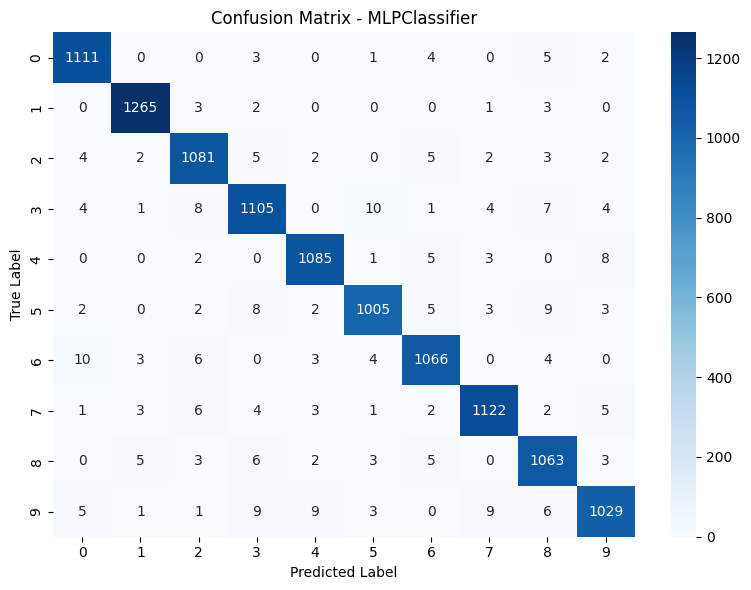

In [14]:
# Skriv ut resultaten
for name, result in results.items():
    print(f"\nModell: {name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:\n", result["classification_report"])

    # Plotta confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(result["confusion_matrix"], annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


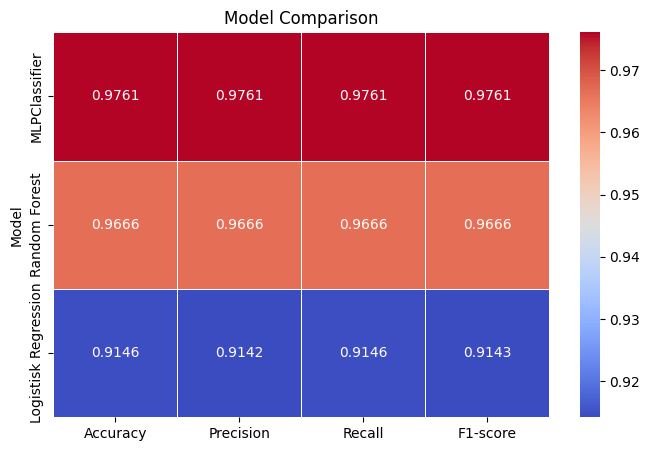

In [15]:
# Jämför modellerna i en heatmap
data = []
for name, result in results.items():
    accuracy = result["accuracy"]
    report_dict = classification_report(y_val, models[name].predict(X_val), output_dict=True)
    precision = report_dict["weighted avg"]["precision"]
    recall = report_dict["weighted avg"]["recall"]
    f1_score = report_dict["weighted avg"]["f1-score"]

    data.append([name, accuracy, precision, recall, f1_score])


df_results = pd.DataFrame(data, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])
df_results = df_results.sort_values(by="Accuracy", ascending=False)
plt.figure(figsize=(8, 5))
sns.heatmap(df_results.set_index("Model"), annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5)
plt.title("Model Comparison")
plt.show()



In [16]:
# Hämtar bästa modellen från results
best_model_name = max(results, key=lambda k: results[k]["accuracy"])
best_model = models[best_model_name] 
print(f"\nBästa modell baserat på valideringsdata: {best_model_name}")



Bästa modell baserat på valideringsdata: MLPClassifier


In [17]:
# Tränar om den bästa modellen på kombinerad tränings- och valideringsdata
best_model.fit(X_train_val, y_train_val)


MLPClassifier(hidden_layer_sizes=(128, 64), learning_rate_init=0.01,
              max_iter=300, random_state=42, solver='sgd')

In [18]:
# Testar den omtränade modellen
y_pred = best_model.predict(X_test)


Klassifikationsrapport (Bästa modell efter omträning):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1343
           1       0.98      0.99      0.99      1600
           2       0.97      0.97      0.97      1380
           3       0.97      0.97      0.97      1433
           4       0.97      0.97      0.97      1295
           5       0.98      0.97      0.98      1273
           6       0.98      0.99      0.98      1396
           7       0.98      0.97      0.97      1503
           8       0.98      0.96      0.97      1357
           9       0.96      0.97      0.96      1420

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



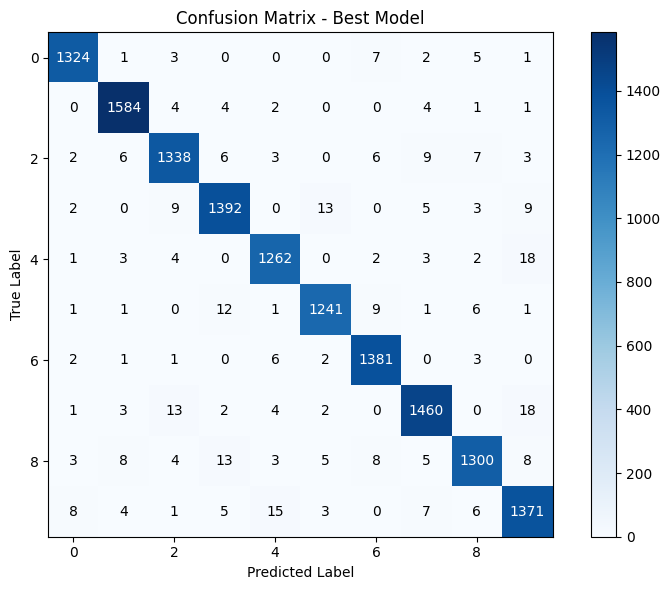

In [19]:
# Skriver ut resultatet
print("\nKlassifikationsrapport (Bästa modell efter omträning):")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Best Model")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

In [20]:
# Sparar den bästa modellen till fil
model_filename = "mnist_best_model.joblib"
joblib.dump(best_model, model_filename)
print(f"Bästa modellen sparad som: {model_filename}")
print(type(best_model))  # För att verifiera att modellen är korrekt

# Spara normaliseringsinformationen till Streamlit-appen
normalization_info = {"scale_factor": 255.0}
joblib.dump(normalization_info, "mnist_normalization.joblib")


Bästa modellen sparad som: mnist_best_model.joblib
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


['mnist_normalization.joblib']